# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.872585,True,6.470943
1,-0.136907,True,4.426715
2,-0.058479,True,5.744680
3,-0.428856,False,-3.366544
4,2.527556,True,13.864637
...,...,...,...
995,0.628969,True,7.301146
996,0.625875,True,6.140807
997,-0.453567,False,-1.802598
998,1.578134,True,10.400047


<AxesSubplot: xlabel='v0'>

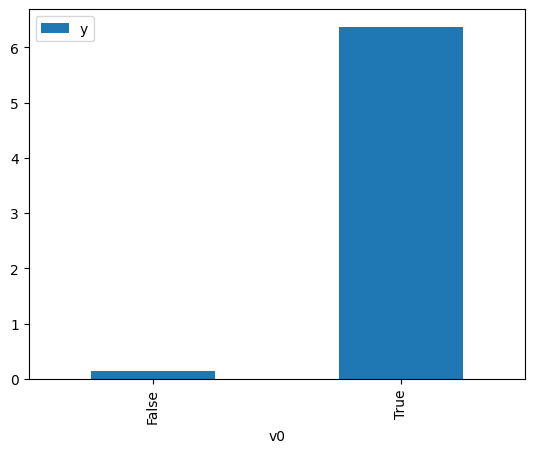

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

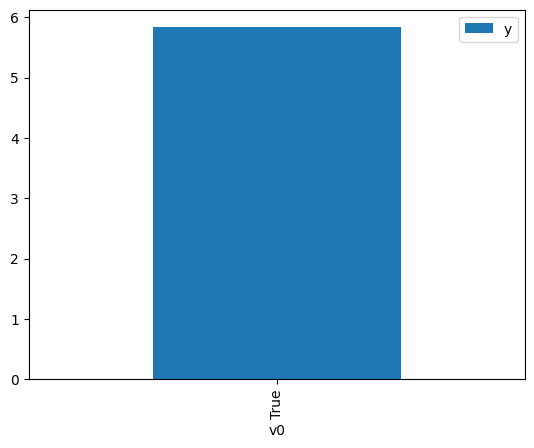

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.428521,False,-1.556853,0.722927,1.383266
1,1.004986,False,1.324884,0.103115,9.697905
2,-0.210946,False,-0.490525,0.618965,1.615600
3,-0.252434,False,0.357998,0.640035,1.562415
4,-1.483956,False,-3.752960,0.962949,1.038477
...,...,...,...,...,...
995,1.356608,False,4.004160,0.050743,19.706994
996,0.630976,False,1.167667,0.206114,4.851675
997,-0.580831,False,-2.523567,0.784274,1.275065
998,0.355246,False,1.980441,0.321261,3.112731


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.900617,True,8.480607,0.873887,1.144313
1,1.949939,True,11.659089,0.985531,1.014682
2,0.789172,True,7.828672,0.844625,1.183958
3,0.641200,True,7.896893,0.797505,1.253910
4,1.739334,True,10.454166,0.977301,1.023227
...,...,...,...,...,...
995,0.330433,True,5.977294,0.666843,1.499604
996,0.191902,True,4.072560,0.596819,1.675551
997,-0.748730,True,2.502435,0.160243,6.240535
998,-0.788980,True,3.078600,0.148795,6.720665


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                          1.806e+04
Date:                Fri, 31 Mar 2023   Prob (F-statistic):                        0.00
Time:                        14:21:38   Log-Likelihood:                         -1418.8
No. Observations:                1000   AIC:                                      2842.
Df Residuals:                     998   BIC:                                      2851.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.8573      0.037     76.954      0.000       2.784       2.930
x2             5.0744      0.051     98.642      0.000       4.973       5.175
==============================================================================
Omnibus:                        3.479   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.176   Jarque-Bera (JB):                3.230
Skew:                           0.084   Prob(JB):                        0.199
Kurtosis:                       2.778   Cond. No.                         2.09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""